In [1]:
# If PuLP is not available in your environment, uncomment the next line (if allowed).
# !pip install pulp

import math
import pandas as pd
from datetime import datetime

# ---- Import your plant file to get nameplate/ramp/mins (no new plant code) ----
from src.models.FEB_turbine_unit_U4 import HydroStorageConfig as HydroStorageConfig1  # to read defaults like max/min MW, ramp, capacity  [1](https://egatucc-my.sharepoint.com/personal/598584_egat_co_th/Documents/Microsoft%20Copilot%20Chat%20Files/FEB_turbine_unit_U4.py)
from src.models.FEB_turbine_unit_U5 import HydroStorageConfig as HydroStorageConfig2
from src.models.FEB_turbine_unit_U6 import HydroStorageConfig as HydroStorageConfig3 
# ---- Import your FiT helper to classify each 15-min block and flag adjusted blocks ----
from revenue_function import detect_time_window_for_aligned_blocks  # window_id & adjusted flag  [2](https://egatucc-my.sharepoint.com/personal/598584_egat_co_th/Documents/Microsoft%20Copilot%20Chat%20Files/revenue_function.py)

import pulp as pl

C:\Users\Jarup\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:22: UserWarning: Pandas requires version '2.10.2' or newer of 'numexpr' (version '2.8.7' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Jarup\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:56: UserWarning: Pandas requires version '1.4.2' or newer of 'bottleneck' (version '1.3.7' currently installed).
  from pandas.core import (


In [2]:
# Example: schedule_df already in memory from your previous steps.
# schedule_df = pd.read_csv("your_input.csv", parse_dates=["ts_start"])
BLOCK_MIN = 15.0
DT_H = BLOCK_MIN / 60.0
KWH_PER_MW_BLOCK = 1000.0 * DT_H  # e.g., 1 MW * 0.25 h = 250 kWh

csv_path = "data/day_ahead_15min_conv.csv" 
schedule_df = pd.read_csv(csv_path, parse_dates=["time"])
schedule_df["ts_start"] = pd.to_datetime(schedule_df["time"])
schedule_df["contract_kwh"] = 45*KWH_PER_MW_BLOCK
schedule_df["egat_plan_kwh"] = 45*0.6*KWH_PER_MW_BLOCK
schedule_df["has_egat_plan_in_win3"] = 0.6*45*KWH_PER_MW_BLOCK
schedule_df['solar_kwh'] = schedule_df["power_MW"] * KWH_PER_MW_BLOCK

schedule_df['fit_rate'] = 4

required_cols = ["ts_start", "fit_rate", "contract_kwh", "egat_plan_kwh", "has_egat_plan_in_win3", "solar_kwh"]
missing = [c for c in required_cols if c not in schedule_df.columns]
assert not missing, f"Missing required columns: {missing}"

schedule_df = schedule_df.sort_values("ts_start").reset_index(drop=True)
nT = len(schedule_df)


In [3]:
ADJUST_FACTOR = 14.0 / 15.0  # must match revenue_function  [2](https://egatucc-my.sharepoint.com/personal/598584_egat_co_th/Documents/Microsoft%20Copilot%20Chat%20Files/revenue_function.py)

def get_base_and_adjust(ts, contract_kwh, egat_plan_kwh, has_egat_plan_in_win3):
    window_id, adjusted = detect_time_window_for_aligned_blocks(ts)
    if window_id == 1:
        base = float(contract_kwh)
    elif window_id == 2:
        base = float(egat_plan_kwh)
    else:  # window 3
        base = float(egat_plan_kwh) if bool(has_egat_plan_in_win3) else float(contract_kwh)
    return base, bool(adjusted)

tmp = schedule_df.apply(
    lambda r: get_base_and_adjust(r["ts_start"], r["contract_kwh"], r["egat_plan_kwh"], r["has_egat_plan_in_win3"]),
    axis=1
)
schedule_df[["base_kwh", "adjusted_flag"]] = pd.DataFrame(tmp.tolist(), index=schedule_df.index)
schedule_df["target_meter_kwh"] = schedule_df["base_kwh"] / schedule_df["adjusted_flag"].map(
    lambda adj: ADJUST_FACTOR if adj else 1.0
)

# Example: flat variable cost for all intervals
DEFAULT_COST_PER_KWH = 1.0  # Baht/kWh (set to your value)
if "turbine_cost_per_kwh" not in schedule_df.columns:
    schedule_df["turbine_cost_per_kwh"] = DEFAULT_COST_PER_KWH
else:
    # Ensure float and non-negative
    schedule_df["turbine_cost_per_kwh"] = schedule_df["turbine_cost_per_kwh"].astype(float).clip(lower=0.0)

schedule_df

,time,power_MW,ts_start,contract_kwh,egat_plan_kwh,has_egat_plan_in_win3,solar_kwh,fit_rate,base_kwh,adjusted_flag,target_meter_kwh,turbine_cost_per_kwh
0,2026-01-26 00:00:00+07:00,0.0,2026-01-26 00:00:00+07:00,11250.0,6750.0,6750.0,0.0,4,6750.0,False,6750.0,1.0
1,2026-01-26 00:15:00+07:00,0.0,2026-01-26 00:15:00+07:00,11250.0,6750.0,6750.0,0.0,4,6750.0,False,6750.0,1.0
2,2026-01-26 00:30:00+07:00,0.0,2026-01-26 00:30:00+07:00,11250.0,6750.0,6750.0,0.0,4,6750.0,False,6750.0,1.0
3,2026-01-26 00:45:00+07:00,0.0,2026-01-26 00:45:00+07:00,11250.0,6750.0,6750.0,0.0,4,6750.0,False,6750.0,1.0
4,2026-01-26 01:00:00+07:00,0.0,2026-01-26 01:00:00+07:00,11250.0,6750.0,6750.0,0.0,4,6750.0,False,6750.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
91,2026-01-26 22:45:00+07:00,0.0,2026-01-26 22:45:00+07:00,11250.0,6750.0,6750.0,0.0,4,6750.0,False,6750.0,1.0
92,2026-01-26 23:00:00+07:00,0.0,2026-01-26 23:00:00+07:00,11250.0,6750.0,6750.0,0.0,4,6750.0,False,6750.0,1.0
93,2026-01-26 23:15:00+07:00,0.0,2026-01-26 23:15:00+07:00,11250.0,6750.0,6750.0,0.0,4,6750.0,False,6750.0,1.0
94,2026-01-26 23:30:00+07:00,0.0,2026-01-26 23:30:00+07:00,11250.0,6750.0,6750.0,0.0,4,6750.0,False,6750.0,1.0


In [4]:
# 1 CFG for all

# # Read canonical constraints from your plant config (no new plant code is created)
# cfg = HydroStorageConfig()  # defaults: max_discharge_mw=12, min_discharge_mw=7, ramp_mw_per_min=6, capacity_mwh=45, initial_soe_mwh=45, eta_discharge=1  [1](https://egatucc-my.sharepoint.com/personal/598584_egat_co_th/Documents/Microsoft%20Copilot%20Chat%20Files/FEB_turbine_unit_U4.py)

# # Turbine-specific constants (3 identical turbines here; adjust if your other units differ)
# TURBINES = ["T1", "T2", "T3"]
# MAX_MW = {u: cfg.max_discharge_mw for u in TURBINES}
# MIN_MW = {u: cfg.min_discharge_mw for u in TURBINES}  # enforced when ON (>0)
# RAMP_MW_PER_MIN = {u: cfg.ramp_mw_per_min for u in TURBINES}

# # Shared reservoir choice:
# # Option A: shared capacity equals a single unit (e.g., 45 MWh)
# # Option B: shared capacity equals sum of three units (e.g., 135 MWh)
# SHARED_CAP_MWH = cfg.capacity_mwh * 1.0   # <-- choose 1.0 or 3.0 multiplier as per your plant
# SHARED_INIT_MWH = cfg.initial_soe_mwh * 1.0
# ETA_DISCH = cfg.eta_discharge if cfg.eta_discharge > 0 else 1.0

In [5]:
cfgs = [HydroStorageConfig1(), HydroStorageConfig2(), HydroStorageConfig3()]
TURBINES = ["T1", "T2", "T3"]
MAX_MW = {u: cfgs[i_u].max_discharge_mw for i_u, u in enumerate(TURBINES)}
MIN_MW = {u: cfgs[i_u].min_discharge_mw for i_u, u in enumerate(TURBINES)}  # enforced when ON (>0)
RAMP_MW_PER_MIN = {u: cfgs[i_u].ramp_mw_per_min for i_u, u in enumerate(TURBINES)}


# ----- Start-up parameters (edit as needed) -----
STARTUP_COST = {"T1": 500.0, "T2": 500.0, "T3": 500.0}  # currency per OFF->ON event
# Optional shutdown cost (usually 0)
SHUTDOWN_COST = {"T1": 0.0, "T2": 0.0, "T3": 0.0}
# Initial ON/OFF state before t=0 (0=OFF, 1=ON)
Y_INIT = {"T1": 0, "T2": 0, "T3": 0}


# Shared reservoir choice:
# Option A: shared capacity equals a single unit (e.g., 45 MWh)
# Option B: shared capacity equals sum of three units (e.g., 135 MWh)
SHARED_CAP_MWH = cfgs[0].capacity_mwh * 1.0   # <-- choose 1.0 or 3.0 multiplier as per your plant
SHARED_INIT_MWH = cfgs[0].initial_soe_mwh * 1.0
ETA_DISCH = cfgs[0].eta_discharge if cfgs[0].eta_discharge > 0 else 1.0

In [6]:
# -------------------- BESS PARAMETERS --------------------
# Power ratings (MW)
BESS_P_CH_MAX = 10.0   # max charging power
BESS_P_DIS_MAX = 10.0  # max discharging power

# Energy capacity (MWh) & initial SoE (MWh)
BESS_E_CAP = 10.0
BESS_E_INIT = 5.0

# Efficiencies (0..1)
BESS_ETA_CH = 0.9
BESS_ETA_DIS = 0.9

# Economics (Baht/kWh). Make BESS more expensive than turbines.
# If you already have schedule_df["turbine_cost_per_kwh"], set BESS cost above its max.
if "turbine_cost_per_kwh" in schedule_df.columns:
    BESS_COST_PER_KWH = float(schedule_df["turbine_cost_per_kwh"].max()) + 0.10
else:
    # If turbine cost is a scalar elsewhere in your code, set a fixed BESS cost > turbine cost
    BESS_COST_PER_KWH = 0.30  # example


In [7]:
prob = pl.LpProblem("Revenue_Maximization_SharedSoE_3Turbines", pl.LpMaximize)

# Index sets
T = range(nT)

# --- Variables ---
p = pl.LpVariable.dicts("p_mw", ((i, t) for i in TURBINES for t in T), lowBound=0.0)   # MW
y = pl.LpVariable.dicts("on", ((i, t) for i in TURBINES for t in T), lowBound=0, upBound=1, cat="Binary")
E = pl.LpVariable.dicts("E_mwh", (t for t in range(nT+1)), lowBound=0.0)               # shared SoE (MWh)

e_turb = pl.LpVariable.dicts("e_turb_kwh", (t for t in T), lowBound=0.0)               # kWh
e_meter = pl.LpVariable.dicts("e_meter_kwh", (t for t in T), lowBound=0.0)             # kWh
e_use = pl.LpVariable.dicts("e_use_kwh", (t for t in T), lowBound=0.0)                 # kWh after 14/15 if adjusted
payable = pl.LpVariable.dicts("payable_kwh", (t for t in T), lowBound=0.0)             # kWh
shortfall = pl.LpVariable.dicts("shortfall_kwh", (t for t in T), lowBound=0.0)         # kWh

# -------------------- BESS VARIABLES --------------------
# Charge & discharge power (MW) per block (non-negative), plus binaries to prevent simultaneity.
p_bess_ch  = pl.LpVariable.dicts("p_bess_ch_mw",  (t for t in T), lowBound=0.0)
p_bess_dis = pl.LpVariable.dicts("p_bess_dis_mw", (t for t in T), lowBound=0.0)
u_bess_ch  = pl.LpVariable.dicts("u_bess_ch",     (t for t in T), lowBound=0, upBound=1, cat="Binary")
u_bess_dis = pl.LpVariable.dicts("u_bess_dis",    (t for t in T), lowBound=0, upBound=1, cat="Binary")

# Net signed BESS power for ramping like your emulator (+ = discharge, - = charge).
p_bess_net = pl.LpVariable.dicts("p_bess_net_mw", (t for t in T), lowBound=None)

# BESS SoE (MWh) at block edges (0..nT)
E_bess = pl.LpVariable.dicts("E_bess_mwh", (t for t in range(nT+1)), lowBound=0.0)

# Energy per block (kWh), useful for objective and meter balance
e_bess_ch  = pl.LpVariable.dicts("e_bess_ch_kwh",  (t for t in T), lowBound=0.0)
e_bess_dis = pl.LpVariable.dicts("e_bess_dis_kwh", (t for t in T), lowBound=0.0)
# Start/stop indicators
# z_start = pl.LpVariable.dicts("z_start", ((i, t) for i in TURBINES for t in T), lowBound=0, upBound=1, cat="Binary")
# z_stop  = pl.LpVariable.dicts("z_stop",  ((i, t) for i in TURBINES for t in T), lowBound=0, upBound=1, cat="Binary")

# --- Initial SoE ---
prob += E[0] == SHARED_INIT_MWH, "Initial_SoE"
# -------------------- BESS INITIAL SoE --------------------
prob += E_bess[0] == BESS_E_INIT, "BESS_Initial_SoE"

# --- Per-block constraints ---
# BIGM = 10_000.0  # big-M used only where necessary

for t in T:
    base = float(schedule_df.loc[t, "base_kwh"])
    solar = float(schedule_df.loc[t, "solar_kwh"])
    # fit = float(schedule_df.loc[t, "fit_rate"])
    adjusted = bool(schedule_df.loc[t, "adjusted_flag"])

    # -------------------- PER-BLOCK BESS CONSTRAINTS --------------------
    prob += p_bess_ch[t]  <= BESS_P_CH_MAX  * u_bess_ch[t],  f"BESS_PchMax_{t}"
    prob += p_bess_dis[t] <= BESS_P_DIS_MAX * u_bess_dis[t], f"BESS_PdisMax_{t}"
    prob += u_bess_ch[t] + u_bess_dis[t] <= 1,               f"BESS_NoSimul_{t}"

    # 3.2 Define net signed power (+dis, -ch) to match emulator's ramp target  # [1](https://egatucc-my.sharepoint.com/personal/598584_egat_co_th/Documents/Microsoft%20Copilot%20Chat%20Files/FEB_bess.py)
    prob += p_bess_net[t] == p_bess_dis[t] - p_bess_ch[t],    f"BESS_NetPower_{t}"

    # 3.3 MW -> kWh per block
    prob += e_bess_ch[t]  == p_bess_ch[t]  * KWH_PER_MW_BLOCK,  f"BESS_eCh_{t}"
    prob += e_bess_dis[t] == p_bess_dis[t] * KWH_PER_MW_BLOCK,  f"BESS_eDis_{t}"

    # 3.4 SoE update with efficiencies (mirror emulator logic: η on the appropriate leg)  # [1](https://egatucc-my.sharepoint.com/personal/598584_egat_co_th/Documents/Microsoft%20Copilot%20Chat%20Files/FEB_bess.py)
    # E_{t+1} = E_t + (η_ch * p_ch * Δt) - (p_dis/η_dis * Δt)
    prob += E_bess[t+1] == E_bess[t] + (p_bess_ch[t] * DT_H * BESS_ETA_CH) - (p_bess_dis[t] * DT_H / BESS_ETA_DIS), f"BESS_SoE_{t}"

    # 3.5 SoE bounds
    prob += E_bess[t+1] >= 0.0,        f"BESS_SoE_LB_{t}"
    prob += E_bess[t+1] <= BESS_E_CAP, f"BESS_SoE_UB_{t}"

    # 1) Power limits with min-on when y=1: 0 <= p_i_t <= MAX*y ;  p_i_t >= MIN*y
    for i in TURBINES:
        prob += p[i, t] <= MAX_MW[i] * y[i, t], f"Max_{i}_{t}"
        prob += p[i, t] >= MIN_MW[i] * y[i, t], f"Min_{i}_{t}"

    # 2) Ramp constraints |p_i_t - p_i_{t-1}| <= ramp * 15min
    # (for t=0, you can assume previous p=0; adjust if you have a known starting output)
    for i in TURBINES:
        ramp_allow = RAMP_MW_PER_MIN[i] * 15.0
        if t == 0:
            # From zero (change this if you have an actual initial setpoint)
            prob += p[i, t] <= ramp_allow, f"RampUp_{i}_{t}"
            # Ramp-down not needed at t=0
        else:
            prob += p[i, t] - p[i, t-1] <= ramp_allow, f"RampUp_{i}_{t}"
            prob += p[i, t-1] - p[i, t] <= ramp_allow, f"RampDown_{i}_{t}"

    # 3) Shared SoE balance: E_{t+1} = E_t - (sum_i p_i_t * DT_H)/eta_discharge
    sum_p_t = pl.lpSum(p[i, t] for i in TURBINES)
    prob += e_turb[t] == sum_p_t * KWH_PER_MW_BLOCK, f"Energy_from_MW_{t}"
    
    # Export meter reads PV + turbine + BESS discharge minus BESS charge (no grid import if e_meter has LB=0)
    prob += e_meter[t] == solar + e_turb[t] + e_bess_dis[t] - e_bess_ch[t], f"MeterDef_{t}"
    # prob += e_meter[t] == solar + e_turb[t], f"MeterDef_{t}"

    # Use energy after adjustment at boundary blocks (06:00, 16:00, 18:00): e_use = e_meter * (14/15) if adjusted else e_meter
    if adjusted:
        prob += e_use[t] == e_meter[t] * ADJUST_FACTOR, f"AdjustedUse_{t}"   # linear scaling
    else:
        prob += e_use[t] == e_meter[t], f"UseNoAdj_{t}"

    # SoE update
    prob += E[t+1] == E[t] - (sum_p_t * DT_H) / ETA_DISCH, f"SoE_{t}"

    # SoE bounds
    prob += E[t+1] >= 0.0, f"SoE_LB_{t}"
    prob += E[t+1] <= SHARED_CAP_MWH, f"SoE_UB_{t}"

    # 4) Payable/shortfall linearization:
    # payable <= e_use; payable <= base; (objective will push payable up)
    prob += payable[t] <= e_use[t], f"Payable_le_use_{t}"
    prob += payable[t] <= base, f"Payable_le_base_{t}"

    # shortfall >= base - e_use; shortfall >= 0 (already)
    prob += shortfall[t] >= base - e_use[t], f"Shortfall_ge_base_minus_use_{t}"

# --- Objective: maximize sum_t fit * (payable - 0.12 * shortfall) ---
penalty_rate = 0.12  # per your revenue function  [2](https://egatucc-my.sharepoint.com/personal/598584_egat_co_th/Documents/Microsoft%20Copilot%20Chat%20Files/revenue_function.py)
obj = []
for t in T:
    fit = float(schedule_df.loc[t, "fit_rate"])
    cost_per_kwh = float(schedule_df.loc[t, "turbine_cost_per_kwh"])
    fi_component = fit * (payable[t] - penalty_rate * shortfall[t])


    tur_cost_component  = cost_per_kwh * e_turb[t] # cost of turbine energy
    bess_cost_component = BESS_COST_PER_KWH * e_bess_dis[t]  # cost only when delivering to the meter

    cost_component = tur_cost_component + bess_cost_component

    obj.append(fi_component - cost_component)
    
    # Start/stop costs (stop cost optional)
    # startup_cost_t = pl.lpSum(STARTUP_COST[i]  * z_start[i, t]  for i in TURBINES)
    # shutdown_cost_t= pl.lpSum(SHUTDOWN_COST[i] * z_stop[i, t]   for i in TURBINES)

    # obj.append(fi_component - cost_component - startup_cost_t - shutdown_cost_t)
    # obj.append(fit * (payable[t] - penalty_rate * shortfall[t]))

prob += pl.lpSum(obj), "Total_Revenue"

print(prob.sense, "Model built.")

-1 Model built.


In [8]:
# Solve
_ = prob.solve(pl.PULP_CBC_CMD(msg=True, warmStart=True))  # You can switch to other solvers if available

print("Status:", pl.LpStatus[prob.status])
print("Objective (total revenue):", pl.value(prob.objective))

# Build result DataFrame
rows = []
for t in T:
    row = {
        "ts_start": schedule_df.loc[t, "ts_start"],
        "fit_rate": schedule_df.loc[t, "fit_rate"],
        "base_kwh": schedule_df.loc[t, "base_kwh"],
        "adjusted_flag": schedule_df.loc[t, "adjusted_flag"],
        "solar_kwh": float(schedule_df.loc[t, "solar_kwh"]),

        # Turbines
        "e_turb_kwh": pl.value(e_turb[t]),
        "e_meter_kwh": pl.value(e_meter[t]),
        "e_use_kwh": pl.value(e_use[t]),
        "payable_kwh": pl.value(payable[t]),
        "shortfall_kwh": pl.value(shortfall[t]),
        "E_end_mwh": pl.value(E[t+1]),
        **{f"p_{i}_mw": pl.value(p[i, t]) for i in TURBINES},
        **{f"on_{i}": int(pl.value(y[i, t]) > 0.5) for i in TURBINES},

        # BESS
        "p_bess_ch_mw":  pl.value(p_bess_ch[t]),
        "p_bess_dis_mw": pl.value(p_bess_dis[t]),
        "p_bess_net_mw": pl.value(p_bess_net[t]),
        "e_bess_ch_kwh":  pl.value(e_bess_ch[t]),
        "e_bess_dis_kwh": pl.value(e_bess_dis[t]),
        "E_bess_end_mwh": pl.value(E_bess[t+1]),
    }
    rows.append(row)

opt_df = pd.DataFrame(rows).sort_values("ts_start").reset_index(drop=True)

# Economics outside revenue_function.py
opt_df["turb_cost_currency"] = opt_df["e_turb_kwh"] * schedule_df["turbine_cost_per_kwh"]
opt_df["bess_cost_currency"] = opt_df["e_bess_dis_kwh"] * BESS_COST_PER_KWH
opt_df["gross_payment_currency"] = (opt_df["payable_kwh"] - 0.12*opt_df["shortfall_kwh"]) * schedule_df["fit_rate"]
opt_df["net_payment_currency"] = opt_df["gross_payment_currency"] - opt_df["turb_cost_currency"] - opt_df["bess_cost_currency"]

print("Gross revenue:", opt_df["gross_payment_currency"].sum())
print("Turbine cost:", opt_df["turb_cost_currency"].sum())
print("BESS cost:", opt_df["bess_cost_currency"].sum())
print("Net revenue:", opt_df["net_payment_currency"].sum())
display(opt_df.head(12))

C:\Users\Jarup\anaconda3\Lib\site-packages\pulp\apis\coin_api.py:112: UserWarning: When using CBC on Windows, warmStart requires keepFiles=True.
  warnings.warn(


Status: Optimal
Objective (total revenue): 2678161.9352663
Gross revenue: 3114000.0
Turbine cost: 426319.7189
BESS cost: 9518.345833700001
Net revenue: 2678161.9352663


,ts_start,fit_rate,base_kwh,adjusted_flag,solar_kwh,e_turb_kwh,e_meter_kwh,e_use_kwh,payable_kwh,shortfall_kwh,...,p_bess_ch_mw,p_bess_dis_mw,p_bess_net_mw,e_bess_ch_kwh,e_bess_dis_kwh,E_bess_end_mwh,turb_cost_currency,bess_cost_currency,gross_payment_currency,net_payment_currency
0,2026-01-26 00:00:00+07:00,4,6750.0,False,0.0,6750.0,6750.0,6750.0,6750.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,6750.0,0.0,27000.0,20250.0
1,2026-01-26 00:15:00+07:00,4,6750.0,False,0.0,6750.0,6750.0,6750.0,6750.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,6750.0,0.0,27000.0,20250.0
2,2026-01-26 00:30:00+07:00,4,6750.0,False,0.0,6750.0,6750.0,6750.0,6750.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,6750.0,0.0,27000.0,20250.0
3,2026-01-26 00:45:00+07:00,4,6750.0,False,0.0,6750.0,6750.0,6750.0,6750.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,6750.0,0.0,27000.0,20250.0
4,2026-01-26 01:00:00+07:00,4,6750.0,False,0.0,6750.0,6750.0,6750.0,6750.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,6750.0,0.0,27000.0,20250.0
5,2026-01-26 01:15:00+07:00,4,6750.0,False,0.0,6750.0,6750.0,6750.0,6750.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,6750.0,0.0,27000.0,20250.0
6,2026-01-26 01:30:00+07:00,4,6750.0,False,0.0,6750.0,6750.0,6750.0,6750.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,6750.0,0.0,27000.0,20250.0
7,2026-01-26 01:45:00+07:00,4,6750.0,False,0.0,6750.0,6750.0,6750.0,6750.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,6750.0,0.0,27000.0,20250.0
8,2026-01-26 02:00:00+07:00,4,6750.0,False,0.0,6750.0,6750.0,6750.0,6750.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,6750.0,0.0,27000.0,20250.0
9,2026-01-26 02:15:00+07:00,4,6750.0,False,0.0,6750.0,6750.0,6750.0,6750.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,6750.0,0.0,27000.0,20250.0


In [9]:

from revenue_function import compute_revenue_rows  # unchanged revenue module  [1](https://egatucc-my.sharepoint.com/personal/598584_egat_co_th/Documents/Microsoft%20Copilot%20Chat%20Files/revenue_function.py)

check_in = pd.DataFrame({
    "ts_start": opt_df["ts_start"],
    "e_read_kwh": opt_df["e_meter_kwh"],                # optimized meter reading
    "fit_rate": schedule_df["fit_rate"],
    "contract_kwh": schedule_df["contract_kwh"],
    "egat_plan_kwh": schedule_df["egat_plan_kwh"],
    "has_egat_plan_in_win3": schedule_df["has_egat_plan_in_win3"],
})
check_out = compute_revenue_rows(check_in)
print("Gross revenue (via revenue_function):", check_out["payment_currency"].sum())


Gross revenue (via revenue_function): 3113999.998208


In [10]:
opt_plot_df = opt_df.merge(
    schedule_df[["ts_start", "contract_kwh", "egat_plan_kwh", "has_egat_plan_in_win3"]],
    on="ts_start", how="left"
).rename(columns={"e_meter_kwh": "meter_e_read_kwh"})

# Now reuse the plotting cells you already have.

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
# plt.rcParams['font.family'] = 'TH Sarabun New'
plt.style.use("seaborn-v0_8-darkgrid")  # Nice default style
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf') # Ensuring matplotlib recognizes the font
mpl.rc('font', family='TH Sarabun New') # Setting the default font to TH Sarabun New
colors = {
    "solar": "#FDB813",
    "turbines": "#1f77b4",
    "meter": "#2ca02c",
    "target": "#d62728",
    "payable": "#9467bd",
    "penalty": "#e377c2",
    "t1": "#1f77b4",
    "t2": "#17becf",
    "t3": "#2ca02c",
    "bess": 'black',
}

In [12]:
from revenue_function import detect_time_window_for_aligned_blocks  # already imported earlier

plot_df = opt_plot_df.copy().sort_values("ts_start").reset_index(drop=True)
plot_df["ts_start"] = pd.to_datetime(plot_df["ts_start"])

# Make a column for window ID (if not present)
if "window_id" not in plot_df.columns:
    plot_df["window_id"] = plot_df["ts_start"].map(lambda ts: detect_time_window_for_aligned_blocks(ts)[0])

# Make a column for 'adjusted_flag' (if not present)
if "adjusted_flag" not in plot_df.columns:
    plot_df["adjusted_flag"] = plot_df["ts_start"].map(lambda ts: detect_time_window_for_aligned_blocks(ts)[1])

# Prepare a time index
t = plot_df["ts_start"]

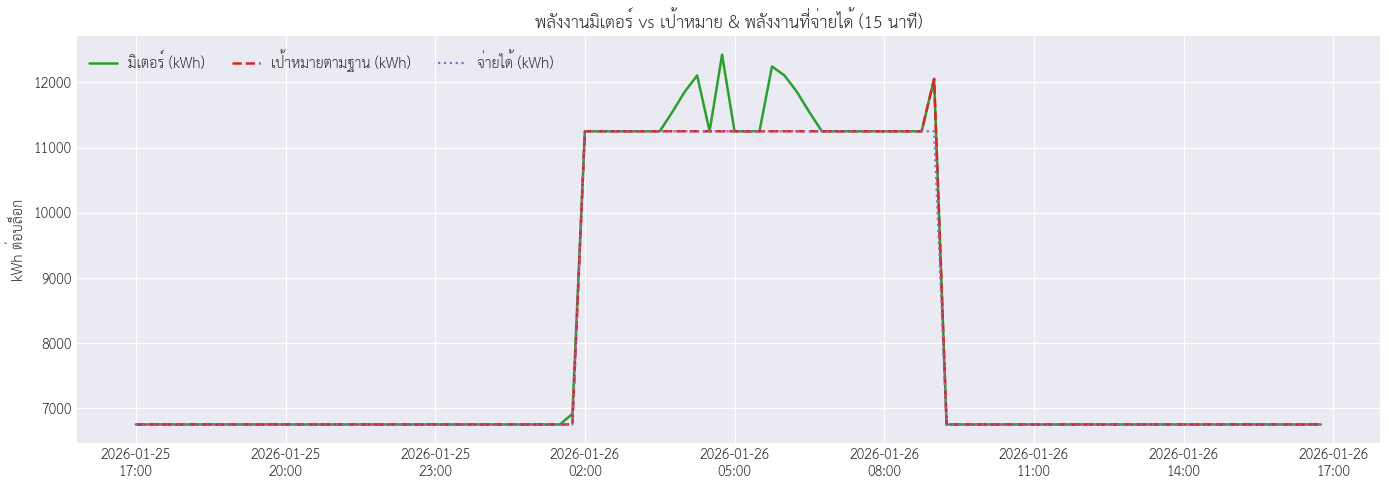

In [13]:
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(t, plot_df["meter_e_read_kwh"], label="มิเตอร์ (kWh)", color=colors["meter"], lw=1.8)
ax.plot(t, schedule_df["target_meter_kwh"], label="เป้าหมายตามฐาน (kWh)", color=colors["target"], lw=1.8, linestyle="--")
ax.plot(t, plot_df["payable_kwh"], label="จ่ายได้ (kWh)", color=colors["payable"], lw=1.6, linestyle=":")

ax.set_title("พลังงานมิเตอร์ vs เป้าหมาย & พลังงานที่จ่ายได้ (15 นาที)")
ax.set_ylabel("kWh ต่อบล็อก")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d\n%H:%M"))
ax.legend(ncols=3, loc="upper left")
plt.tight_layout()
plt.show()

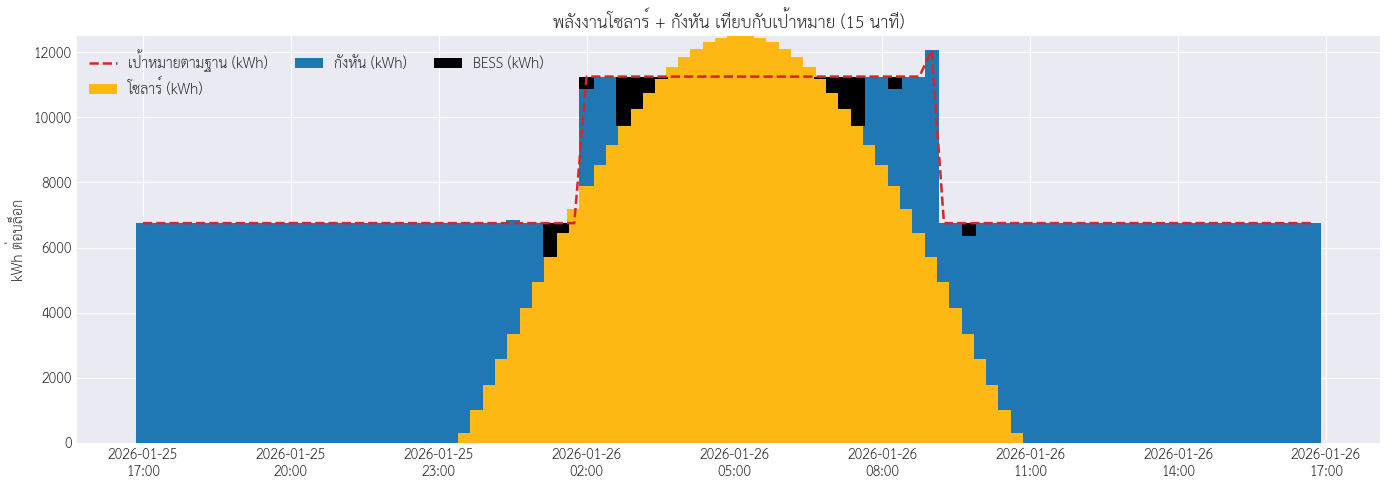

In [14]:
fig, ax = plt.subplots(figsize=(14, 5))
plot_df["turbines_kwh"] = (plot_df["p_T1_mw"] + plot_df["p_T2_mw"] + plot_df["p_T3_mw"])*1000/4
solar = plot_df["solar_kwh"].clip(lower=0)
turb = plot_df["turbines_kwh"].clip(lower=0)
bess = plot_df["p_bess_net_mw"].clip(lower=0)*1000/4

ax.bar(t, solar, label="โซลาร์ (kWh)", color=colors["solar"], width=0.012, align="center")
ax.bar(t, turb, bottom=solar, label="กังหัน (kWh)", color=colors["turbines"], width=0.012, align="center")
ax.bar(t, bess, bottom=solar+turb, label="BESS (kWh)", color=colors["bess"], width=0.012, align="center")

ax.plot(t, schedule_df["target_meter_kwh"], color=colors["target"], lw=1.8, linestyle="--", label="เป้าหมายตามฐาน (kWh)")

ax.set_title("พลังงานโซลาร์ + กังหัน เทียบกับเป้าหมาย (15 นาที)")
ax.set_ylabel("kWh ต่อบล็อก")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d\n%H:%M"))
ax.legend(ncols=3, loc="upper left")
plt.tight_layout()
plt.show()

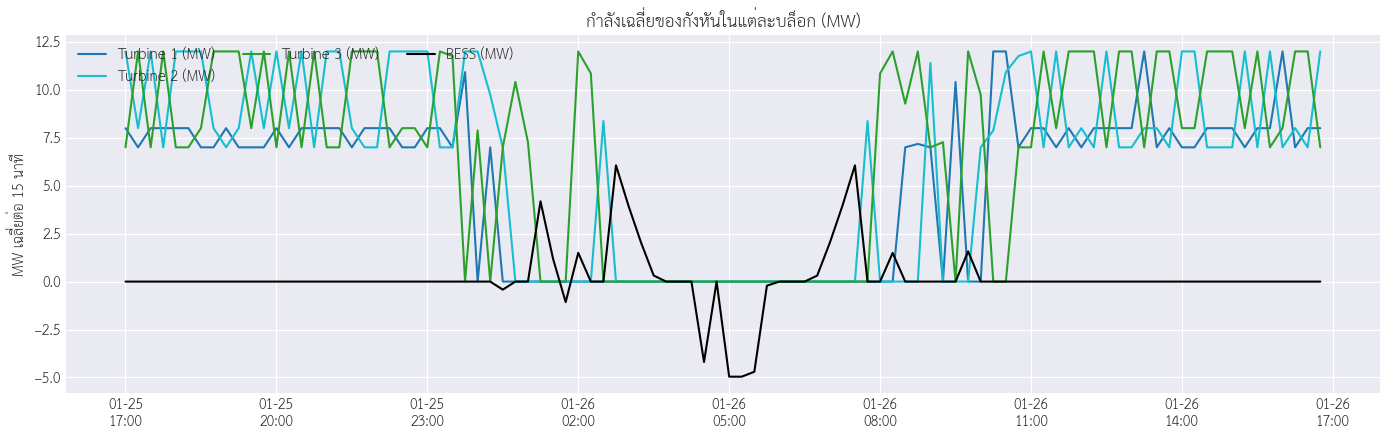

In [15]:
need_cols = {"p_T1_mw", "p_T2_mw", "p_T3_mw"}
if need_cols.issubset(plot_df.columns):
    fig, ax = plt.subplots(figsize=(14, 4.5))
    ax.plot(t, plot_df["p_T1_mw"], label="Turbine 1 (MW)", color=colors["t1"], lw=1.5)
    ax.plot(t, plot_df["p_T2_mw"], label="Turbine 2 (MW)", color=colors["t2"], lw=1.5)
    ax.plot(t, plot_df["p_T3_mw"], label="Turbine 3 (MW)", color=colors["t3"], lw=1.5)
    ax.plot(t, plot_df["p_bess_net_mw"], label="BESS (MW)", color=colors["bess"], lw=1.5)
    ax.set_title("กำลังเฉลี่ยของกังหันในแต่ละบล็อก (MW)")
    ax.set_ylabel("MW เฉลี่ยต่อ 15 นาที")
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d\n%H:%M"))
    ax.legend(ncols=3, loc="upper left")
    plt.tight_layout()
    plt.show()
else:
    print("Skip Plot C: average MW columns not found (turb1_mw/turb2_mw/turb3_mw).")

In [16]:
ADJ = schedule_df["adjusted_flag"].astype(bool)
need_meter_kwh = schedule_df["base_kwh"] / ADJUST_FACTOR
need_meter_kwh[~ADJ] = schedule_df.loc[~ADJ, "base_kwh"]

schedule_df["need_turb_kwh_to_hit_base"] = (need_meter_kwh - schedule_df["solar_kwh"]).clip(lower=0)
schedule_df["max_turb_kwh_per_block"] = (sum(MAX_MW.values())) * (15/60.0) * 1000.0  # 3*12*0.25*1000 = 9000 kWh
schedule_df["e_use_max_kwh"] = (schedule_df["solar_kwh"] + schedule_df["max_turb_kwh_per_block"]) * schedule_df["adjusted_flag"].map(lambda a: ADJUST_FACTOR if a else 1.0)
schedule_df["always_short_here"] = schedule_df["e_use_max_kwh"] + 1e-6 < schedule_df["base_kwh"]

print("Blocks infeasible to hit base even at max:",
      int(schedule_df["always_short_here"].sum()), "of", len(schedule_df))

print("Initial shared SoE (MWh):", SHARED_INIT_MWH,
      " Capacity (MWh):", SHARED_CAP_MWH)

Blocks infeasible to hit base even at max: 0 of 96
Initial shared SoE (MWh): 10000.0  Capacity (MWh): 10000.0


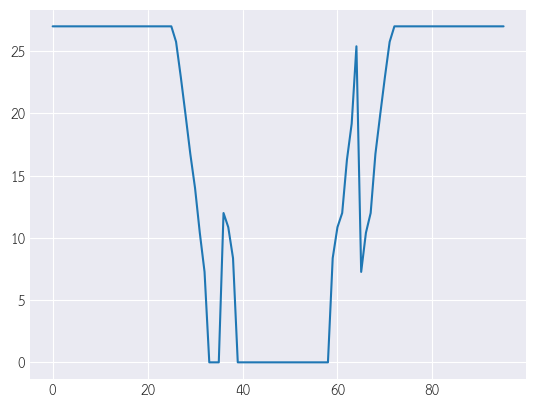

In [17]:
plt.plot(plot_df.loc[:, list(need_cols)].sum(axis=1))